In [23]:
import gymnasium as gym
import numpy as np

class DisturbedLunarLander(gym.Wrapper):
    def __init__(self, env, failure_prob=0.05, force_magnitude=10.0):
        super().__init__(env)
        self.failure_prob = failure_prob
        self.force_magnitude = force_magnitude

        # Unwrap to access the original LunarLander instance
        base = env
        while hasattr(base, "env"):
            base = base.env
        self.base_env = base  # This is now the actual LunarLander

    def step(self, action):
        # Random engine failure
        if np.random.rand() < self.failure_prob:
            action = 0  # Override with no-op

        obs, reward, terminated, truncated, info = self.env.step(action)

        # Random horizontal force
        if np.random.rand() < self.failure_prob:
            try:
                self.base_env.lander.ApplyForceToCenter(
                    (np.random.uniform(-self.force_magnitude, self.force_magnitude), 0),
                    True
                )
            except AttributeError:
                print("[Warning] lander not available at this step.")

        return obs, reward, terminated, truncated, info




In [24]:
import gymnasium as gym  # <-- Important!
import os
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from gymnasium.wrappers import RecordEpisodeStatistics
from stable_baselines3.common.monitor import Monitor
log_dir ="./logs_d/"
os.makedirs(log_dir, exist_ok=True)

base_env = gym.make("LunarLander-v3")
disturbed_env = DisturbedLunarLander(base_env, failure_prob=0.05, force_magnitude=15.0)
env = RecordEpisodeStatistics(disturbed_env)
env = Monitor(env, log_dir) 


# Initialize DQN agent
model = DQN(
    "MlpPolicy",
    env,
    buffer_size=100000,
    learning_starts=10000,
    batch_size=128,
    exploration_fraction=0.2,
    target_update_interval=1000,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=1,
)
model.learn(total_timesteps=500_000)

# Save model
model.save("dqn_lunarlander_d")


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 80       |
|    ep_rew_mean      | -80.2    |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3164     |
|    time_elapsed     | 0        |
|    total_timesteps  | 320      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 83.8     |
|    ep_rew_mean      | -155     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3448     |
|    time_elapsed     | 0        |
|    total_timesteps  | 670      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 83.5     |
|    ep_rew_mean      | -158     |
|    exploration_rate | 0.99     |
| t

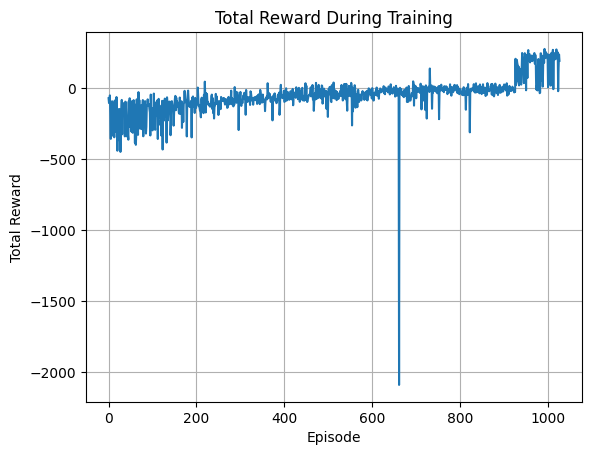

In [25]:
import pandas as pd

monitor_file = os.path.join(log_dir, "monitor.csv")
df = pd.read_csv(monitor_file, skiprows=1)  # First row is a comment

# Plot reward over episodes
plt.plot(df["r"])  # 'r' is total reward
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward During Training")
plt.grid(True)
plt.show()


In [21]:
import time


# Load environment with rendering

base_env = gym.make("LunarLander-v3")
disturbed_env = DisturbedLunarLander(base_env, failure_prob=0.05, force_magnitude=15.0)
env = RecordEpisodeStatistics(disturbed_env)

# Load trained model
model = DQN.load("dqn_lunarlander_d", env=env)

obs, _ = env.reset()  # <-- FIXED: unpack obs and info
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)  # New Gym returns 5 items
    if done or truncated:
        obs, _ = env.reset()
    time.sleep(0.02)

env.close()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


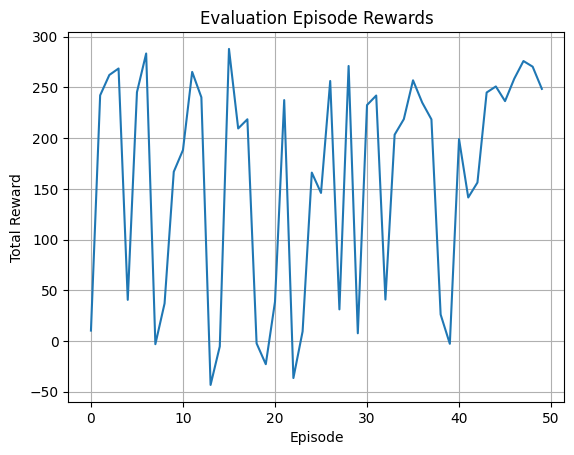

In [8]:
import matplotlib.pyplot as plt


# Create evaluation env with RecordEpisodeStatistics
eval_env = RecordEpisodeStatistics(gym.make("LunarLander-v3"))

# Load trained model
model = DQN.load("dqn_lunarlander_d", env=eval_env)

episode_rewards = []
n_eval_episodes = 50  # or more, depending on how detailed you want the plot

for _ in range(n_eval_episodes):
    obs, info = eval_env.reset()
    done, truncated = False, False
    total_reward = 0
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = eval_env.step(action)
        total_reward += reward
    episode_rewards.append(total_reward)

# Plotting
import matplotlib.pyplot as plt

plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Evaluation Episode Rewards")
plt.grid(True)
plt.show()





In [28]:
import gymnasium as gym
import numpy as np
import time
from stable_baselines3 import DQN

# Custom disturbance wrapper
class DisturbedLunarLander(gym.Wrapper):
    def __init__(self, env, failure_prob=0.05, force_magnitude=10.0):
        super().__init__(env)
        self.failure_prob = failure_prob
        self.force_magnitude = force_magnitude

        # Unwrap to access base LunarLander for physics manipulation
        base = env
        while hasattr(base, "env"):
            base = base.env
        self.base_env = base

    def step(self, action):
        disturbance_triggered = False
        force_applied = (0, 0)

        # Random engine failure
        if np.random.rand() < self.failure_prob:
            action = 0  # Disable engine
            print("[!] Engine failure simulated!")
            disturbance_triggered = True

        obs, reward, terminated, truncated, info = self.env.step(action)

        # Random horizontal force
        if np.random.rand() < self.failure_prob:
            force_applied = (np.random.uniform(-self.force_magnitude, self.force_magnitude), 0)
            try:
                self.base_env.lander.ApplyForceToCenter(force_applied, True)
                print(f"[!] Random force applied to lander: {force_applied}")
                disturbance_triggered = True
            except AttributeError:
                print("[!] Warning: Lander not initialized yet")

        if disturbance_triggered:
            info["disturbed"] = True
            info["force"] = force_applied

        return obs, reward, terminated, truncated, info

# Create disturbed environment
base_env = gym.make("LunarLander-v3", render_mode="human")
env = DisturbedLunarLander(base_env, failure_prob=0.08, force_magnitude=20.0)

# Load trained model
model = DQN.load("dqn_lunarlander_d", env=env)

# Reset environment
obs, _ = env.reset()
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    # Optional: Highlight disturbances in the console
    if info.get("disturbed", False):
        print(f"[*] Disturbance handled | Force: {info['force']}")

    time.sleep(0.02)

    if done or truncated:
        print(">>> Episode finished. Resetting environment...\n")
        obs, _ = env.reset()
        #done = False

env.close()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[!] Engine failure simulated!
[*] Disturbance handled | Force: (0, 0)
[!] Engine failure simulated!
[!] Random force applied to lander: (-6.341885684794075, 0)
[*] Disturbance handled | Force: (-6.341885684794075, 0)
[!] Random force applied to lander: (-18.516163466179396, 0)
[*] Disturbance handled | Force: (-18.516163466179396, 0)
[!] Engine failure simulated!
[*] Disturbance handled | Force: (0, 0)
[!] Engine failure simulated!
[*] Disturbance handled | Force: (0, 0)
[!] Engine failure simulated!
[*] Disturbance handled | Force: (0, 0)
[!] Engine failure simulated!
[*] Disturbance handled | Force: (0, 0)
[!] Engine failure simulated!
[!] Random force applied to lander: (-19.49502980224071, 0)
[*] Disturbance handled | Force: (-19.49502980224071, 0)
[!] Random force applied to lander: (9.29206225515096, 0)
[*] Disturbance handled | Force: (9.29206225515096, 0)
[!] Engine failure simulated!
[*] Disturbance h